<a href="https://colab.research.google.com/github/zeiosis/ffnet-summary-prediction/blob/main/finalfinal_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 33.7 MB/s 
     |████████████████████████████████| 6.6 MB 27.8 MB/s 
     |████████████████████████████████| 596 kB 64.0 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [63]:
import pandas as pd
from re import findall, sub
import torch
from transformers import pipeline

try:
    cuda_id = torch.cuda.current_device()
except:
    cuda_id = -1

droplist = ['Crime',
 'Fantasy',
 'General',
 'Horror',
 'Mystery',
 'Parody',
 'Poetry',
 'Sci_Fi',
 'Spiritual',
 'Supernatural',
 'Suspense',
 'Tragedy',
 'Western']


def webtext2dict(text):
    slistlite = findall(r"iews\n.*\nR", text)
    slist = []
    for x in slistlite:
        slist.append(x[5:len(x)-2])
        
    glistlite = findall(r"h - .*? - C|h - Ch", text)
    glist = []
    for x in glistlite:
        glist.append(x[4:len(x)-4])
    
    sumgenr_dict = {}
    for x in range(len(slist)):
        sumgenr_dict[slist[x]] = glist[x]
        
    keyremoveset = set()
    for key in sumgenr_dict:
        if len(sumgenr_dict[key]) > 30:
            keyremoveset.add(key)
    
    for x in keyremoveset:
        sumgenr_dict.pop(x, None)

    return sumgenr_dict
 

def dictclean(inputdict):
    #1st pass for Hurt/Comfort > Hurt_Comfort, s-f>s_f naming inconsistencies b/c vars dont support dashes
    #2nd pass to get rid of other slashes (k/j > [k, j])

    
    hc_repl_list = []
    
    for key in inputdict:
        if 'Hurt/Comfort' in inputdict[key]:
            hc_repl_list.append(key)
            
    for x in hc_repl_list:
        inputdict[x] = sub('Hurt/Comfort', 'Hurt_Comfort', inputdict[x])
        
        
    sf_repl_list = []
    
    for key in inputdict:
        if 'Sci-Fi' in inputdict[key]:
            sf_repl_list.append(key)
            
    for x in sf_repl_list:
        inputdict[x] = sub('Sci-Fi', 'Sci_Fi', inputdict[x])
    
    #1st pass done
    
    for key in inputdict:
        inputdict[key] = inputdict[key].split('/')
        
    return inputdict
        

def ffdict_to_df(dfdict):
    df = pd.DataFrame()
    df = df.assign(Summary=0, Adventure=0, Angst=0, Crime=0, Drama=0, Family=0,\
                   Fantasy=0, Friendship=0, General=0, Horror=0, Humor=0,\
                   Hurt_Comfort=0, Mystery=0, Parody=0, Poetry=0, Romance=0,\
                   Sci_Fi=0, Spiritual=0, Supernatural=0, Suspense=0, Tragedy=0, Western=0) #works for ffnet.
    for x in dfdict:
        r2 = {}
        r2['Summary'] = x
        for values in dfdict[x]:
            if values != '':
                r2[values] = 1
        df = df.append(r2, ignore_index=True)
        
    df = df.fillna(0)
    return df
 

class Summary:
    def __init__(self, text, genre1, genre2, pred_genre1=None, pred_genre2=None):
        self.text = text
        self.genre1 = genre1
        self.genre2 = genre2 # None for 1-tagged works
        self.pred_genre1 = pred_genre1
        self.pred_genre2 = pred_genre2

    def pred_acc(self):
        if self.genre2 == None:
            if self.genre1 in [self.pred_genre1, self.pred_genre2]:
                return '1t1r'
            else:
                return '1t0r'
        else: #make sure self.genre1 is present
            if self.genre1 in [self.pred_genre1, self.pred_genre2] and self.genre2 in [self.pred_genre1, self.pred_genre2]:
                return '2t2r'
            elif self.genre1 in [self.pred_genre1, self.pred_genre2] or self.genre2 in [self.pred_genre1, self.pred_genre2]:
                return '2t1r'
            else:
                return '2t0r'
    

class FFWebtext:
    def __init__(self, text=None, filename=None, content=None): # content is the only one used, others are options to write to it
        if text == None: #use filename to content
            self.filename = filename

            f = open(self.filename, "r")
            self.content = f.read()
            f.close 
        
        else: #text to content
            self.content = text

    def to_df(self, drop_rare=True): #drops rares by default 
        r1 = webtext2dict(self.content)
        r1 = dictclean(r1)
        df = ffdict_to_df(r1)
    
        if drop_rare == False:
            return df
        else:
            df = df.drop(labels=droplist, axis=1)
            return df
    
    def to_csv(self, filename):
        df = self.to_df()
        df.to_csv(filename, index=False) #no index, capital S summary

    def to_dict(self, drop_rare=True):
        r1 = webtext2dict(self.content)
        r1 = dictclean(r1)
        dellist = []
        
        if drop_rare == False:
            print(1)
            return r1
        else:
            print(2)
            for x in r1:
                try:
                    if r1[x][0] in droplist or r1[x][1] in droplist:
                        dellist.append(x)
                    else:
                        pass
                except:
                    if r1[x][0] in droplist:
                        dellist.append(x)
                    else:
                        pass
        
        for x in dellist:
            del r1[x]
            
        return r1

    def to_summarylist(self, drop_rare=True):
        summary_dict = self.to_dict(drop_rare=drop_rare)
        summarylist = []

        for x in summary_dict:
            try:
                summarylist.append(Summary(x, summary_dict[x][0], summary_dict[x][1]))
            except:
                summarylist.append(Summary(x, summary_dict[x][0], None))      

        return summarylist #list of Summary objects to feed into SummarySet


class SummarySet:
    def __init__(self, summarylist=[]):
        self.summarylist = summarylist
    
    def predict(self, model, revision=None, family='zdr'): #defaults to latest revision, as per HF API
        summarylist = self.summarylist
        if family == 'zdr':   
            if revision == None:
                classifier = pipeline(model=model, return_all_scores=True, device=cuda_id)
            else: #defining classifier pipeline to be used 
                classifier = pipeline(model=model, revision=revision, return_all_scores=True, device=cuda_id)
            
            summary_text_list = [x.text for x in summarylist]
            preds = classifier(summary_text_list)
            preds_list = []

            for x in preds:
                sorted_probs = sorted(x, key=lambda n: n['score'], reverse=True)
                preds_list.append([sorted_probs[0], sorted_probs[1]])

            for x in range(len(summary_text_list)):
                summarylist[x].pred_genre1 = preds_list[x][0]['label']
                summarylist[x].pred_genre2 = preds_list[x][1]['label']

            return summarylist
        
        else:
            classifier = pipeline(model=model, device=cuda_id)
            fsumlist = [x.text for x in summarylist]
            
            fromsum = classifier(
                fsumlist,
                candidate_labels=['Adventure', 'Angst', 'Drama', 'Family', 'Friendship',
                'Humor', 'Hurt_Comfort', 'Romance']
                )
            

            for x in range(len(fromsum)):
              summarylist[x].pred_genre1 = str(fromsum[x]['labels'][0])
              summarylist[x].pred_genre2 = str(fromsum[x]['labels'][1])

            return summarylist

    def accuracy(self):
      summarylist = self.summarylist
      c2t2r = 0
      c2t1r = 0
      c2t0r = 0
      c1t1r = 0
      c1t0r = 0

      from collections import Counter

      new_list = [x.pred_acc() for x in summarylist]

      cn = Counter(new_list)
      mz = {'2t2r':0, '1t1r':0, '2t1r':0, '1t0r':0, '2t0r':0}

      for k,v in cn.items():
        mz[k] = v
      
      retval = [[], []]

      for key in mz:
        retval[0].append(key)
        retval[1].append(mz[key]) #append value to 2nd, append key to 1st
      
      return retval

    def visual_acc(self, ret=False):
      acclist = self.accuracy()
      df = pd.DataFrame([acclist[1]], columns=acclist[0])
      df = df.applymap(lambda x: x / len(self.summarylist) * 100)
      if ret == False:
        df.plot.barh(stacked=True, color={'2t2r':'blue', '1t1r':'green', '2t1r':'yellow', '1t0r':'red', '2t0r':'purple'})

      else:
        return df




In [64]:
ffwt1 = FFWebtext(filename='ffdump7.txt')
slist1 = ffwt1.to_summarylist()

2


In [65]:
ss1 = SummarySet(slist1)

In [66]:
k0 = ss1.predict('zdreiosis/ff_analysis_5', revision='1454370')

Downloading:   0%|          | 0.00/2.78k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


In [67]:
ss1.summarylist[52].text

'On the run criminal Cobra accidentally, by no means of his own volition, adopts a dragon? Yeah…that’s not disaster waiting to happen. A short-story of my two morally grey dragon slayers becoming bros ;)'

In [68]:
ss1.summarylist[52].pred_genre1

'Romance'

In [69]:
ss1.summarylist[52].pred_genre2

'Friendship'

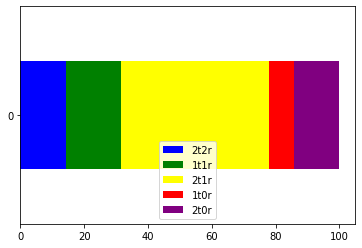

In [70]:
ss1.visual_acc()